# set up

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

results = "/home/c/dkorot/AI4GOOD/ai4good-mushroom/results/few_shot_overall_results.json"
df = pd.read_json(results)

df_no_tmp = df.drop(columns=["temp", "mix_strategy"])
df_condensed = (
    df_no_tmp.groupby(['shot', 'model', 'alpha', 'prompt_set', 'lr', 'weight_decay', 'split', 'backbone'], as_index=False)
      .agg({'top1': "first", 'top5': "first", 'balanced_acc': "first", 'macro_f1': "first", 'per_class_acc': "first"})
)
df = df_condensed

In [5]:
df.head(0)

,shot,model,alpha,prompt_set,lr,weight_decay,split,backbone,top1,top5,balanced_acc,macro_f1,per_class_acc


# Zero Shot

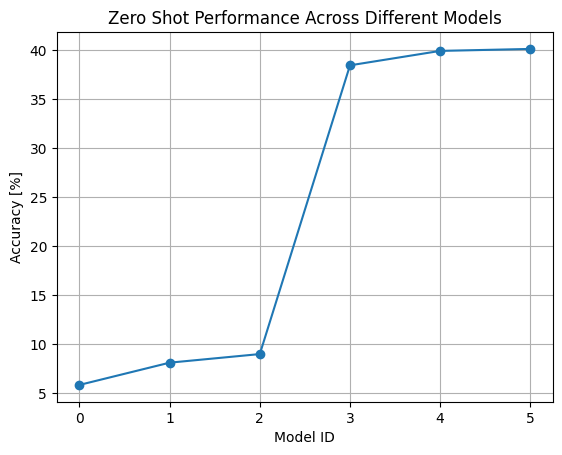

0	5.808350668662801	ViT-B-16
1	8.0800927984446	ViT-B-32-quickgelu
2	8.957422202888601	ViT-L-14
3	38.4276226561854	PE-Core-bigG-14-448
4	39.8999912301002	ViT-gopt-16-SigLIP2-384
5	40.1020851459878	ViT-H-14-378-quickgelu


In [6]:
zero_shots = df[(df['split'] == "test") & (df['model'] == "zero-shot")].sort_values(by='macro_f1', ascending=True)
zero_shot_test = np.array(zero_shots["macro_f1"])*100
backbones = np.array(zero_shots["backbone"])
plt.plot(range(len(zero_shot_test)), zero_shot_test, 'o-')
plt.title(f"Zero Shot Performance Across Different Models")
plt.ylabel(f"Accuracy [%]")
plt.xlabel("Model ID")
plt.grid()
plt.show()

for x, y, z in zip(range(len(zero_shot_test)), zero_shot_test, backbones):
    print(f"{x}\t{y}\t{z}")


# Few shots (Specificly for B32)

## Diffrent Shots

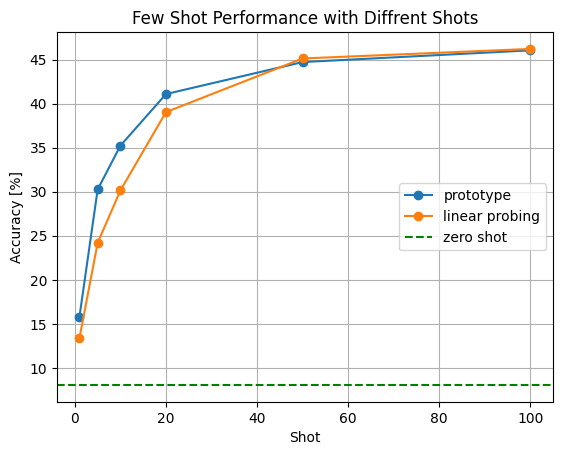

1	13.397242452393629	15.809741789562832
5	24.197580939562748	30.25659401979469
10	30.154157499190138	35.22873623015629
20	39.03344985175231	41.07922382088169
50	45.11597987592274	44.70984396410189
100	46.200657493539374	46.03860959246103

zero shot: 8.0800927984446


In [7]:
import pandas as pd

unique_text = "/home/c/dkorot/AI4GOOD/ai4good-mushroom/results/old/few_shot_table_all_backbones_copy.csv"
unique_df = pd.read_csv(unique_text)

# Filter backbone + test split
diff_shots_b32 = unique_df[
    (unique_df['backbone'] == "ViT-B-32-quickgelu") &
    (unique_df['split'] == "test")
]

# Separate models
lin_df = diff_shots_b32[diff_shots_b32['model'] == "linear+prompts"]
prt_df = diff_shots_b32[diff_shots_b32['model'] == "prototype+prompts"]

# Best macro_f1 per shot
best_lin = lin_df.loc[lin_df.groupby('shot')['macro_f1'].idxmax()].sort_values('shot')
best_prt = prt_df.loc[prt_df.groupby('shot')['macro_f1'].idxmax()].sort_values('shot')

shot_b32 = list(best_lin['shot'])
linear_b32 = np.array(best_lin["macro_f1"])*100
prototype_b32 = np.array(best_prt["macro_f1"])*100

plt.plot(shot_b32, prototype_b32, 'o-', label = 'prototype')
plt.plot(shot_b32, linear_b32, 'o-', label = 'linear probing')
plt.axhline(y=8.0800927984446, linestyle='--', color='green', label='zero shot')
plt.title(f"Few Shot Performance with Diffrent Shots")
plt.ylabel(f"Accuracy [%]")
plt.xlabel("Shot")
plt.legend()
plt.grid()
plt.show()

for x, y, z in zip(shot_b32, linear_b32, prototype_b32):
    print(f"{x}\t{y}\t{z}")
print(f"\nzero shot: 8.0800927984446")


## Determine Best Hyperparameters
We observe the which hyperparameter combination gives the best balanced account, as we are interested in the best hyperparemters across all classes. These turn out to be:  

**shots:** 100  
**Model:** Linear probing  
**Prompt set:** Delta prompts generate by us  
**Learning rate:** 3e-2   
**weight_decay:** 0  
**balanced_acc:** 69.02%  

In [8]:
top_rows = df[(df['split'] == "val") & (df['backbone'] == "ViT-B-32-quickgelu")].sort_values(by='balanced_acc', ascending=False).head(5)
top_rows

,shot,model,alpha,prompt_set,lr,weight_decay,split,backbone,top1,top5,balanced_acc,macro_f1,per_class_acc
16879,100,linear+prompts,1.0,delta,0.03,0.0000,val,ViT-B-32-quickgelu,0.701012,0.922772,0.690195,0.657745,"{'Agaricus augustus': 0.52, 'Agaricus xanthode..."
16889,100,linear+prompts,1.0,delta,0.03,0.0001,val,ViT-B-32-quickgelu,0.702869,0.922772,0.687365,0.656220,"{'Agaricus augustus': 0.64, 'Agaricus xanthode..."
17019,100,linear+prompts,1.0,ensemble,0.03,0.0005,val,ViT-B-32-quickgelu,0.698642,0.921875,0.687114,0.654039,"{'Agaricus augustus': 0.58, 'Agaricus xanthode..."
17239,100,linear+prompts,1.0,v1,0.03,0.0000,val,ViT-B-32-quickgelu,0.698578,0.921875,0.686815,0.654208,"{'Agaricus augustus': 0.64, 'Agaricus xanthode..."
17259,100,linear+prompts,1.0,v1,0.03,0.0005,val,ViT-B-32-quickgelu,0.703509,0.922387,0.686753,0.654703,"{'Agaricus augustus': 0.64, 'Agaricus xanthode..."


In [9]:
final_parameters_b32 = {
    "SHOTS": 100,
    "MODEL": "linear+prompts",
    "PROMPT_SET": "delta",
    "LR": 0.03,
    "WD": 0.0000,
    "SLPIT": "val",
    "DEFAULT_PRETRAINED": {"ViT-B-32-quickgelu": "openai"}
}

## Extracting best alpha per classof the best hyperparameters

In [10]:
# Filter to the chosen config
chosen_cfg = {
    "shot": final_parameters_b32["SHOTS"],
    "model": final_parameters_b32["MODEL"],
    "prompt_set": final_parameters_b32["PROMPT_SET"],
    "lr": final_parameters_b32["LR"],
    "weight_decay": final_parameters_b32["WD"],
    "split": final_parameters_b32["SLPIT"],
    "backbone": list(final_parameters_b32["DEFAULT_PRETRAINED"].keys())[0]
}

cfg_df = df.copy()
for k, v in chosen_cfg.items():
    cfg_df = cfg_df[cfg_df[k] == v]

if cfg_df.empty:
    raise ValueError("No runs matched the chosen configuration — verify the filters.")

# Parse per_class_acc dictionaries
def parse_dict(x):
    if isinstance(x, dict):
        return x
    return ast.literal_eval(x)
cfg_df["per_class_acc_parsed"] = cfg_df["per_class_acc"].apply(parse_dict)


# For each class, find the a that gives best performance

# class -> alpha -> metric
class_alpha_metrics = {}
for _, row in cfg_df.iterrows():
    alpha = row["alpha"]
    class_dict = row["per_class_acc_parsed"]
    for cls, acc in class_dict.items():
        class_alpha_metrics.setdefault(cls, {})
        class_alpha_metrics[cls].setdefault(alpha, [])
        class_alpha_metrics[cls][alpha].append(acc)

# Compute best alpha
best_alpha_per_class_b32 = []
for cls, alpha_dict in class_alpha_metrics.items():
    # average metric for each alpha
    alpha_mean = {alpha: sum(vals)/len(vals) for alpha, vals in alpha_dict.items()}
    # pick alpha with highest mean accuracy
    best_alpha = max(alpha_mean.items(), key=lambda x: x[1])[0]
    best_metric = alpha_mean[best_alpha]
    best_alpha_per_class_b32.append({
        "class": cls,
        "best_alpha": best_alpha,
        "best_metric": best_metric
    })
best_alpha_df_b32 = pd.DataFrame(best_alpha_per_class_b32).sort_values("class")

# print per row with 2 decimal digits each, sorted by best metric
for _, row in best_alpha_df_b32.sort_values("best_metric", ascending=True).iterrows():
    print(f"Best Alpha: {row['best_alpha']:.2f}, Best Metric: {100*row['best_metric']:.2f}%, class: {row['class']} ")

# ------------------------------

Best Alpha: 1.00, Best Metric: 27.08%, class: Suillus luteus 
Best Alpha: 1.00, Best Metric: 33.33%, class: Tylopilus felleus 
Best Alpha: 1.00, Best Metric: 33.73%, class: Leccinum aurantiacum 
Best Alpha: 1.00, Best Metric: 43.90%, class: Armillaria borealis 
Best Alpha: 1.00, Best Metric: 44.00%, class: Amanita amerirubescens 
Best Alpha: 1.00, Best Metric: 44.74%, class: Boletus reticulatus 
Best Alpha: 1.00, Best Metric: 44.90%, class: Armillaria mellea 
Best Alpha: 1.00, Best Metric: 46.51%, class: Paxillus involutus 
Best Alpha: 1.00, Best Metric: 47.22%, class: Psathyrella candolleana 
Best Alpha: 1.00, Best Metric: 47.50%, class: Amanita rubescens 
Best Alpha: 1.00, Best Metric: 47.69%, class: Leccinum versipelle 
Best Alpha: 1.00, Best Metric: 47.92%, class: Boletus pallidus 
Best Alpha: 1.00, Best Metric: 48.00%, class: Phellinus igniarius 
Best Alpha: 1.00, Best Metric: 48.33%, class: Daedaleopsis confragosa 
Best Alpha: 1.00, Best Metric: 50.00%, class: Pleurotus ostreatus

### Analyse Best Alpha Per Class

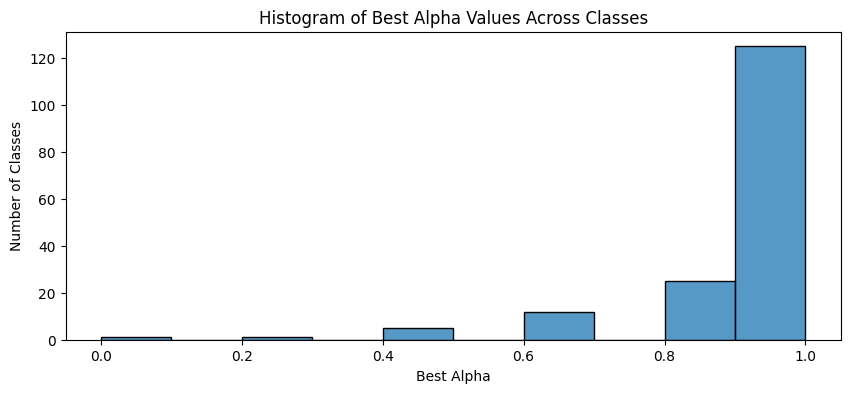

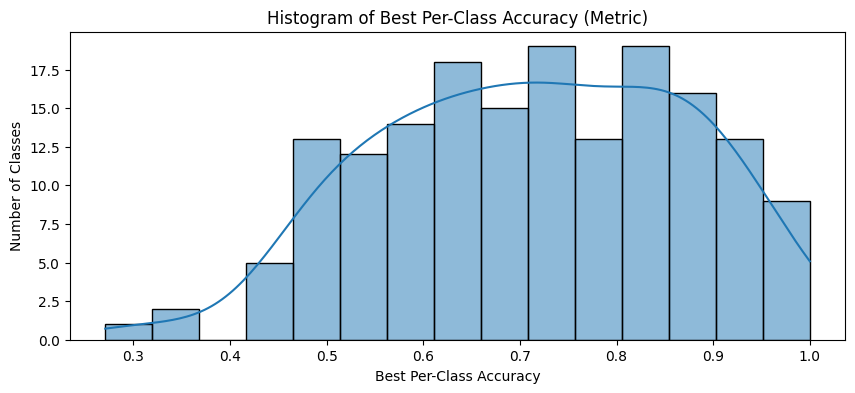

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of best alphas
plt.figure(figsize=(10, 4))
sns.histplot(best_alpha_df_b32["best_alpha"], kde=False, bins=10)
plt.title("Histogram of Best Alpha Values Across Classes")
plt.xlabel("Best Alpha")
plt.ylabel("Number of Classes")
plt.show()


# Histogram of best per-class metrics
plt.figure(figsize=(10, 4))
sns.histplot(best_alpha_df_b32["best_metric"], kde=True, bins=15)
plt.title("Histogram of Best Per-Class Accuracy (Metric)")
plt.xlabel("Best Per-Class Accuracy")
plt.ylabel("Number of Classes")
plt.show()


## Export best alpha

In [12]:
# out put into a jason file as a dictionary of class -> best_alpha
best_alpha_dict = {row['class']: row['best_alpha'] for _, row in best_alpha_df_b32.iterrows()}
best_alpha_dict_file = "/home/c/dkorot/AI4GOOD/ai4good-mushroom/results/best_alpha_b32.json"
# pd.Series(best_alpha_dict).to_json(best_alpha_dict_file)           # UNCOMENT WHEN SAVING BEST ALPHA
print(f"Best alpha per class saved to {best_alpha_dict_file}")

Best alpha per class saved to /home/c/dkorot/AI4GOOD/ai4good-mushroom/results/best_alpha_b32.json


## Best Few Shot

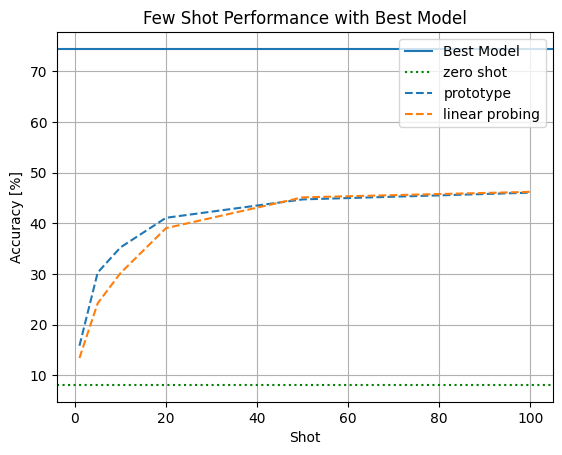

1	13.397242452393629	15.809741789562832
5	24.197580939562748	30.25659401979469
10	30.154157499190138	35.22873623015629
20	39.03344985175231	41.07922382088169
50	45.11597987592274	44.70984396410189
100	46.200657493539374	46.03860959246103

zero shot: 8.0800927984446
Best model: 74.42192472748912


In [13]:
plt.axhline(y=74.42192472748912, linestyle='-', label='Best Model')
plt.axhline(y=8.0800927984446, linestyle=':', color='green', label='zero shot')
plt.plot(shot_b32, prototype_b32, '--', label = 'prototype')
plt.plot(shot_b32, linear_b32, '--', label = 'linear probing')
plt.title(f"Few Shot Performance with Best Model")
plt.ylabel(f"Accuracy [%]")
plt.xlabel("Shot")
plt.legend()
plt.grid()
plt.show()

for x, y, z in zip(shot_b32, linear_b32, prototype_b32):
    print(f"{x}\t{y}\t{z}")
print(f"\nzero shot: 8.0800927984446")
print(f"Best model: 74.42192472748912")

# BEST BACKBONE

## Diffrent shots

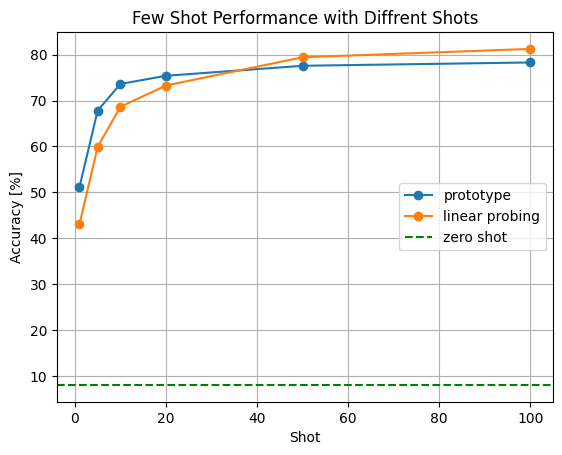

1	43.02055229045967	51.13459951029223
5	59.95073012784387	67.8201739007735
10	68.64662234715612	73.61525284289618
20	73.27264209508822	75.39206103474287
50	79.42727882972504	77.56791141283848
100	81.23932664283106	78.29272275753583

zero shot: 8.0800927984446


In [14]:
import pandas as pd

unique_text = "/home/c/dkorot/AI4GOOD/ai4good-mushroom/results/old/few_shot_table_all_backbones_copy.csv"
unique_df = pd.read_csv(unique_text)

# Filter backbone + test split
diff_shots_meta = unique_df[
    (unique_df['backbone'] == "PE-Core-bigG-14-448") &
    (unique_df['split'] == "test")
]

# Separate models
lin_df = diff_shots_meta[diff_shots_meta['model'] == "linear+prompts"]
prt_df = diff_shots_meta[diff_shots_meta['model'] == "prototype+prompts"]

# Best macro_f1 per shot
best_lin = lin_df.loc[lin_df.groupby('shot')['macro_f1'].idxmax()].sort_values('shot')
best_prt = prt_df.loc[prt_df.groupby('shot')['macro_f1'].idxmax()].sort_values('shot')

shot_meta = list(best_lin['shot'])
linear_meta = np.array(best_lin["macro_f1"])*100
prototype_meta = np.array(best_prt["macro_f1"])*100

plt.plot(shot_meta, prototype_meta, 'o-', label = 'prototype')
plt.plot(shot_meta, linear_meta, 'o-', label = 'linear probing')
plt.axhline(y=8.0800927984446, linestyle='--', color='green', label='zero shot')
plt.title(f"Few Shot Performance with Diffrent Shots")
plt.ylabel(f"Accuracy [%]")
plt.xlabel("Shot")
plt.legend()
plt.grid()
plt.show()

for x, y, z in zip(shot_meta, linear_meta, prototype_meta):
    print(f"{x}\t{y}\t{z}")
print(f"\nzero shot: 8.0800927984446")


## Determine Best Hyperparameters
We observe the which hyperparameter combination gives the best balanced account, as we are interested in the best hyperparemters across all classes. These turn out to be:  

**shots:** 100  
**Model:** Linear probing  
**Prompt set:** Delta prompts generate by us  
**Learning rate:** 3e-2  
**weight_decay:** 1e-4  
**balanced_acc:** 90.23%  

In [15]:
top_rows = df[(df['split'] == "val")].sort_values(by='balanced_acc', ascending=False).head(5)
top_rows

,shot,model,alpha,prompt_set,lr,weight_decay,split,backbone,top1,top5,balanced_acc,macro_f1,per_class_acc
16887,100,linear+prompts,1.0,delta,0.03,0.0001,val,PE-Core-bigG-14-448,0.898309,0.988601,0.902895,0.885762,"{'Agaricus augustus': 0.9, 'Agaricus xanthoder..."
16897,100,linear+prompts,1.0,delta,0.03,0.0005,val,PE-Core-bigG-14-448,0.899910,0.989690,0.902283,0.886811,"{'Agaricus augustus': 0.9, 'Agaricus xanthoder..."
17117,100,linear+prompts,1.0,names,0.03,0.0000,val,PE-Core-bigG-14-448,0.899590,0.988922,0.902186,0.886081,"{'Agaricus augustus': 0.9, 'Agaricus xanthoder..."
17137,100,linear+prompts,1.0,names,0.03,0.0005,val,PE-Core-bigG-14-448,0.899654,0.988986,0.902030,0.886575,"{'Agaricus augustus': 0.9, 'Agaricus xanthoder..."
16997,100,linear+prompts,1.0,ensemble,0.03,0.0000,val,PE-Core-bigG-14-448,0.897541,0.988986,0.901971,0.884744,"{'Agaricus augustus': 0.9, 'Agaricus xanthoder..."


In [16]:
final_parameters_meta = {
    "SHOTS": 100,
    "MODEL": "linear+prompts",
    "PROMPT_SET": "delta",
    "LR": 0.03,
    "WD": 0.0001,
    "SLPIT": "val",
    "DEFAULT_PRETRAINED": {"PE-Core-bigG-14-448": "meta"},
}

## Extracting best alpha per class of the best hyperparameters

In [17]:
# Filter to the chosen config
chosen_cfg = {
    "shot": final_parameters_meta["SHOTS"],
    "model": final_parameters_meta["MODEL"],
    "prompt_set": final_parameters_meta["PROMPT_SET"],
    "lr": final_parameters_meta["LR"],
    "weight_decay": final_parameters_meta["WD"],
    "split": final_parameters_meta["SLPIT"],
    "backbone": list(final_parameters_meta["DEFAULT_PRETRAINED"].keys())[0]
}

cfg_df = df.copy()
for k, v in chosen_cfg.items():
    cfg_df = cfg_df[cfg_df[k] == v]

if cfg_df.empty:
    raise ValueError("No runs matched the chosen configuration — verify the filters.")

# Parse per_class_acc dictionaries
def parse_dict(x):
    if isinstance(x, dict):
        return x
    return ast.literal_eval(x)
cfg_df["per_class_acc_parsed"] = cfg_df["per_class_acc"].apply(parse_dict)


# For each class, find the a that gives best performance

# class -> alpha -> metric
class_alpha_metrics = {}
for _, row in cfg_df.iterrows():
    alpha = row["alpha"]
    class_dict = row["per_class_acc_parsed"]
    for cls, acc in class_dict.items():
        class_alpha_metrics.setdefault(cls, {})
        class_alpha_metrics[cls].setdefault(alpha, [])
        class_alpha_metrics[cls][alpha].append(acc)

# Compute best alpha
best_alpha_per_class_meta = []
for cls, alpha_dict in class_alpha_metrics.items():
    # average metric for each alpha
    alpha_mean = {alpha: sum(vals)/len(vals) for alpha, vals in alpha_dict.items()}
    # pick alpha with highest mean accuracy
    best_alpha = max(alpha_mean.items(), key=lambda x: x[1])[0]
    best_metric = alpha_mean[best_alpha]
    best_alpha_per_class_meta.append({
        "class": cls,
        "best_alpha": best_alpha,
        "best_metric": best_metric
    })
best_alpha_df_meta = pd.DataFrame(best_alpha_per_class_meta).sort_values("class")

# print per row with 2 decimal digits each, sorted by best metric
for _, row in best_alpha_df_meta.sort_values("best_metric", ascending=True).iterrows():
    print(f"Best Alpha: {row['best_alpha']:.2f}, Best Metric: {100*row['best_metric']:.2f}%, class: {row['class']} ")

# ------------------------------

Best Alpha: 1.00, Best Metric: 57.83%, class: Leccinum aurantiacum 
Best Alpha: 1.00, Best Metric: 65.83%, class: Daedaleopsis confragosa 
Best Alpha: 1.00, Best Metric: 67.71%, class: Suillus luteus 
Best Alpha: 1.00, Best Metric: 68.42%, class: Boletus reticulatus 
Best Alpha: 1.00, Best Metric: 70.00%, class: Trametes ochracea 
Best Alpha: 1.00, Best Metric: 70.00%, class: Phellinus igniarius 
Best Alpha: 1.00, Best Metric: 75.00%, class: Imleria badia 
Best Alpha: 1.00, Best Metric: 75.00%, class: Trametes betulina 
Best Alpha: 1.00, Best Metric: 75.38%, class: Leccinum versipelle 
Best Alpha: 0.80, Best Metric: 75.51%, class: Armillaria mellea 
Best Alpha: 0.80, Best Metric: 77.08%, class: Pleurotus pulmonarius 
Best Alpha: 0.80, Best Metric: 77.14%, class: Leccinum albostipitatum 
Best Alpha: 1.00, Best Metric: 77.61%, class: Pseudevernia furfuracea 
Best Alpha: 1.00, Best Metric: 77.78%, class: Phaeophyscia orbicularis 
Best Alpha: 1.00, Best Metric: 78.05%, class: Daedaleopsis 

### Analyse Best Alpha Per Class

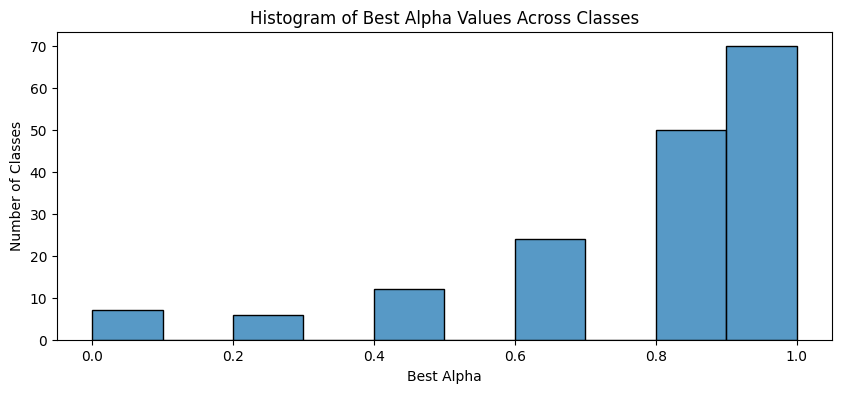

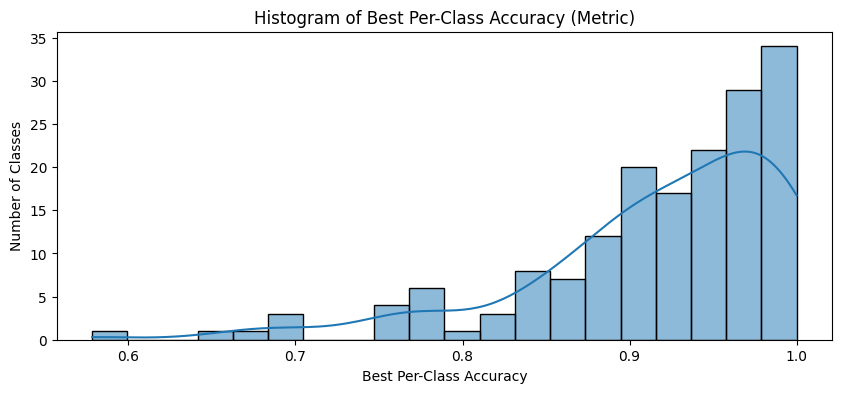

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of best alphas
plt.figure(figsize=(10, 4))
sns.histplot(best_alpha_df_meta["best_alpha"], kde=False, bins=10)
plt.title("Histogram of Best Alpha Values Across Classes")
plt.xlabel("Best Alpha")
plt.ylabel("Number of Classes")
plt.show()


# Histogram of best per-class metrics
plt.figure(figsize=(10, 4))
sns.histplot(best_alpha_df_meta["best_metric"], kde=True, bins=20)
plt.title("Histogram of Best Per-Class Accuracy (Metric)")
plt.xlabel("Best Per-Class Accuracy")
plt.ylabel("Number of Classes")
plt.show()


## compare models

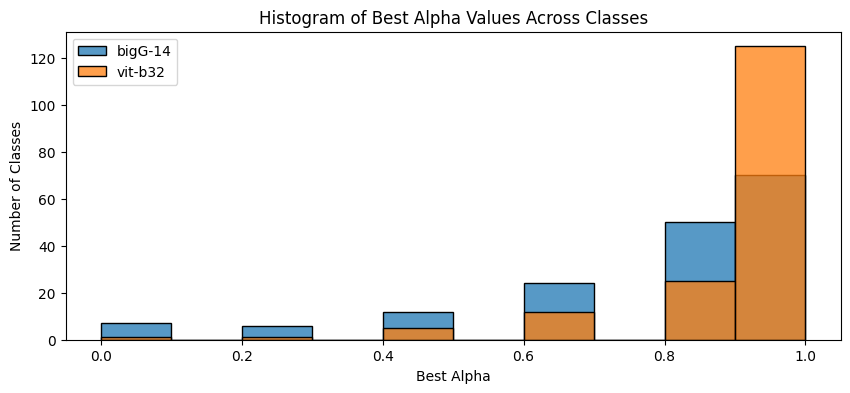

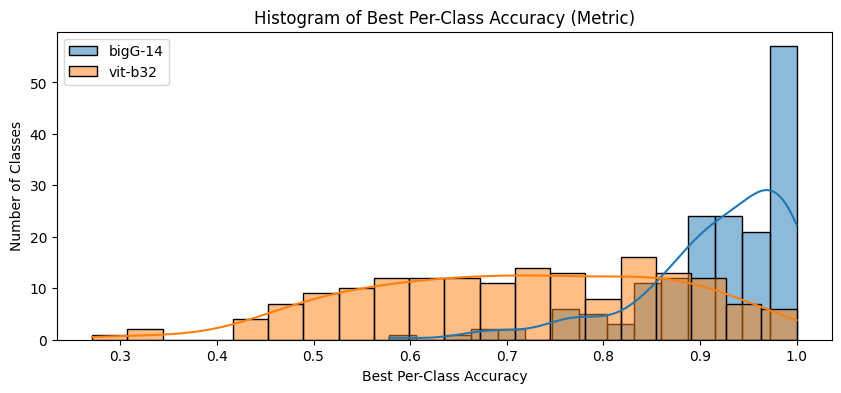

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of best alphas
plt.figure(figsize=(10, 4))
sns.histplot(best_alpha_df_meta["best_alpha"], kde=False, bins=10, label="bigG-14")
sns.histplot(best_alpha_df_b32["best_alpha"], kde=False, bins=10, label="vit-b32")
plt.title("Histogram of Best Alpha Values Across Classes")
plt.xlabel("Best Alpha")
plt.ylabel("Number of Classes")
plt.legend()
plt.show()


# Histogram of best per-class metrics
plt.figure(figsize=(10, 4))
sns.histplot(best_alpha_df_meta["best_metric"], kde=True, bins=15, label="bigG-14")
sns.histplot(best_alpha_df_b32["best_metric"], kde=True, bins=20, label="vit-b32")
plt.title("Histogram of Best Per-Class Accuracy (Metric)")
plt.xlabel("Best Per-Class Accuracy")
plt.ylabel("Number of Classes")
plt.legend()
plt.show()


## Export best alpha

In [21]:
# out put into a jason file as a dictionary of class -> best_alpha
best_alpha_dict = {row['class']: row['best_alpha'] for _, row in best_alpha_df_meta.iterrows()}
best_alpha_dict_file = "/home/c/dkorot/AI4GOOD/ai4good-mushroom/results/best_alpha_meta.json"
# pd.Series(best_alpha_dict).to_json(best_alpha_dict_file)           # UNCOMENT WHEN SAVING BEST ALPHA
print(f"Best alpha per class saved to {best_alpha_dict_file}")

Best alpha per class saved to /home/c/dkorot/AI4GOOD/ai4good-mushroom/results/best_alpha_meta.json


## Best Model

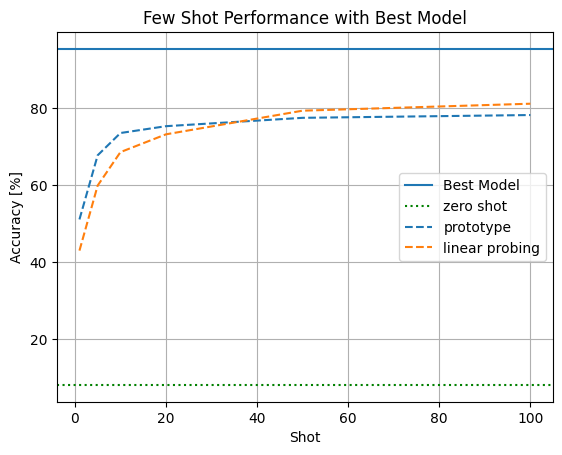

1	43.02055229045967	51.13459951029223
5	59.95073012784387	67.8201739007735
10	68.64662234715612	73.61525284289618
20	73.27264209508822	75.39206103474287
50	79.42727882972504	77.56791141283848
100	81.23932664283106	78.29272275753583

zero shot: 8.0800927984446

Best model: 95.49246419088594


In [22]:
plt.axhline(y=95.49246419088594, linestyle='-', label='Best Model')
plt.axhline(y=8.0800927984446, linestyle=':', color='green', label='zero shot')
plt.plot(shot_meta, prototype_meta, '--', label = 'prototype')
plt.plot(shot_meta, linear_meta, '--', label = 'linear probing')
plt.title(f"Few Shot Performance with Best Model")
plt.ylabel(f"Accuracy [%]")
plt.xlabel("Shot")
plt.legend()
plt.grid()
plt.show()

for x, y, z in zip(shot_meta, linear_meta, prototype_meta):
    print(f"{x}\t{y}\t{z}")
print(f"\nzero shot: 8.0800927984446") 
print(f"\nBest model: 95.49246419088594")

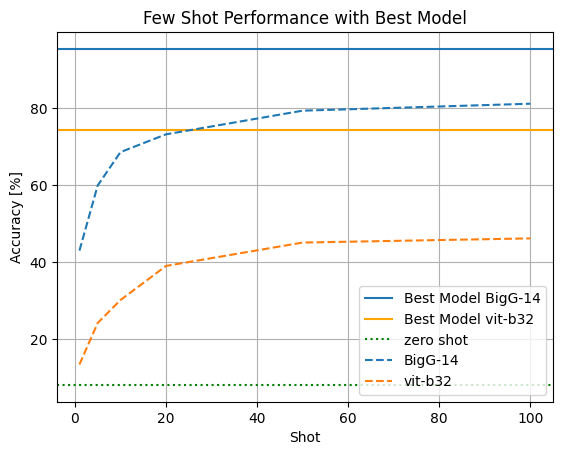

1	43.02055229045967	13.397242452393629
5	59.95073012784387	24.197580939562748
10	68.64662234715612	30.154157499190138
20	73.27264209508822	39.03344985175231
50	79.42727882972504	45.11597987592274
100	81.23932664283106	46.200657493539374

zero shot: 8.0800927984446
Best model bit-b32: 95.49246419088594
Best model bigG-14: 95.49246419088594


In [23]:
plt.axhline(y=95.49246419088594, linestyle='-', label='Best Model BigG-14')
plt.axhline(y=74.42192472748912, linestyle='-', color='orange', label='Best Model vit-b32')
plt.axhline(y=8.0800927984446, linestyle=':', color='green', label='zero shot')
plt.plot(shot_meta, linear_meta, '--', label = 'BigG-14')
plt.plot(shot_meta, linear_b32, '--', label = 'vit-b32')
plt.title(f"Few Shot Performance with Best Model")
plt.ylabel(f"Accuracy [%]")
plt.xlabel("Shot")
plt.legend()
plt.grid()
plt.show()

for x, y, z in zip(shot_meta, linear_meta, linear_b32):
    print(f"{x}\t{y}\t{z}")
print(f"\nzero shot: 8.0800927984446") 
print(f"Best model bit-b32: 95.49246419088594")
print(f"Best model bigG-14: 95.49246419088594")